In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import os 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats
from ese.analysis.analysis_utils.plot_utils import get_prop_color_palette
from ese.analysis.analysis_utils.parse_sweep import get_global_optimal_parameter, get_per_subject_optimal_values
sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
pd.set_option('display.max_rows', 50)
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_OCTA_Benchmark'
    # root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark'
    # root: '/storage/vbutoi/scratch/ESE/inference/10_26_24_Roads_FULLRES_Benchmark'
    # root: '/storage/vbutoi/scratch/ESE/inference/10_28_24_WMH_AllHospitals_Benchmark'
    inference_group: 
        # - 'Sweep_Threshold'
        - 'Sweep_Temperature'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

### Useful cell for controlling the plotting functions.

In [3]:
######This cells controls what gets plotted in the following cells so we don't have to change each one
# x_key = 'threshold'
# y_key = 'hard_RAVE'
# xtick_range = np.arange(0, 1.1, 0.1)
# cmap = 'viridis_r'
# aspect = 1
# x_lims = (0, 1)
# y_lims = (-0.5, 4)

x_key = 'temperature'
y_key = 'soft_RAVE'
xtick_range = np.arange(0, 2.1, 0.1)
cmap = 'magma_r'
aspect = 2
x_lims = (0, 2)
y_lims = (-0.5, 4)

# Plotting Calls

In [4]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

Finished loading inference stats.
Log amounts: log_root                                                                         log_set                                              
/storage/vbutoi/scratch/ESE/inference/10_25_24_OCTA_Benchmark/Sweep_Temperature  20241025_124511-74GF-901892f6aa41b4912eb7103342d9a825    3640
                                                                                 20241025_124515-3J1A-9889a8ae741cda6f8337909765550dad    3640
                                                                                 20241025_124519-QE2B-f746e05815df694058d3cc028fd0e18d    1820
                                                                                 20241025_124524-H07R-40be4680d5b49b992dd3c06daef70ae4    1820
                                                                                 20241025_124528-3ORX-6c77262a024db07b2ff1232127e6e27d    3640
                                                                                 20241025_124532-UT8J-8

In [5]:
def dataset(inference_data_class):
    return inference_data_class.split('.')[-1]

inference_df.augment(dataset)

In [6]:
# for ikey in inference_df.keys():
#     print(ikey)

In [7]:
cols_to_keep = [
    'soft_abs_area_estimation_error',
    'soft_log_abs_area_estimation_error',
    'hard_abs_area_estimation_error',
    'hard_log_abs_area_estimation_error',
    'soft_RAVE',
    'hard_RAVE',
    'dataset',
    'loss_func_class',
    'threshold',
    'temperature',
    'hard_volume',
    'soft_volume',
    'gt_volume',
    'data_id',
    'split'
]
# Filter out the columns we want to keep
exp_df = inference_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [8]:
##############################################################################################################
# This cell is quite important, it allows us to see the base soft volume for each data_id and loss_func_class
##############################################################################################################
# We want to add a base soft volume column to let us so what the uncalibrated volume is.
bsv = exp_df[exp_df['temperature'] == 1.01][['data_id', 'loss_func_class', 'soft_volume']].drop_duplicates().reset_index(drop=True)
# Make a new column that is the combination of data_id and loss_func_class
bsv['data_id_experiment_model_dir'] = bsv['data_id'] + '_' + bsv['loss_func_class']
exp_df['data_id_experiment_model_dir'] = exp_df['data_id'] + '_' + exp_df['loss_func_class']
# Drop the columns data_id and loss_func_class
bsv = bsv.drop(columns=['data_id', 'loss_func_class'])
# Convert this to a dictionary mapping from data_id to base soft volume
bsv_dict = dict(zip(bsv['data_id_experiment_model_dir'], bsv['soft_volume']))
# Make a new column of exp_df, called base_soft_volume, where the value is the corresponding value for the data_id of that row in the bsv_dict
exp_df['base_soft_volume'] = exp_df['data_id_experiment_model_dir'].map(bsv_dict)

In [9]:
# We need to make sure that the cal split goes first.
exp_df = exp_df.sort_values('split', ascending=True)

<Figure size 2160x1440 with 0 Axes>

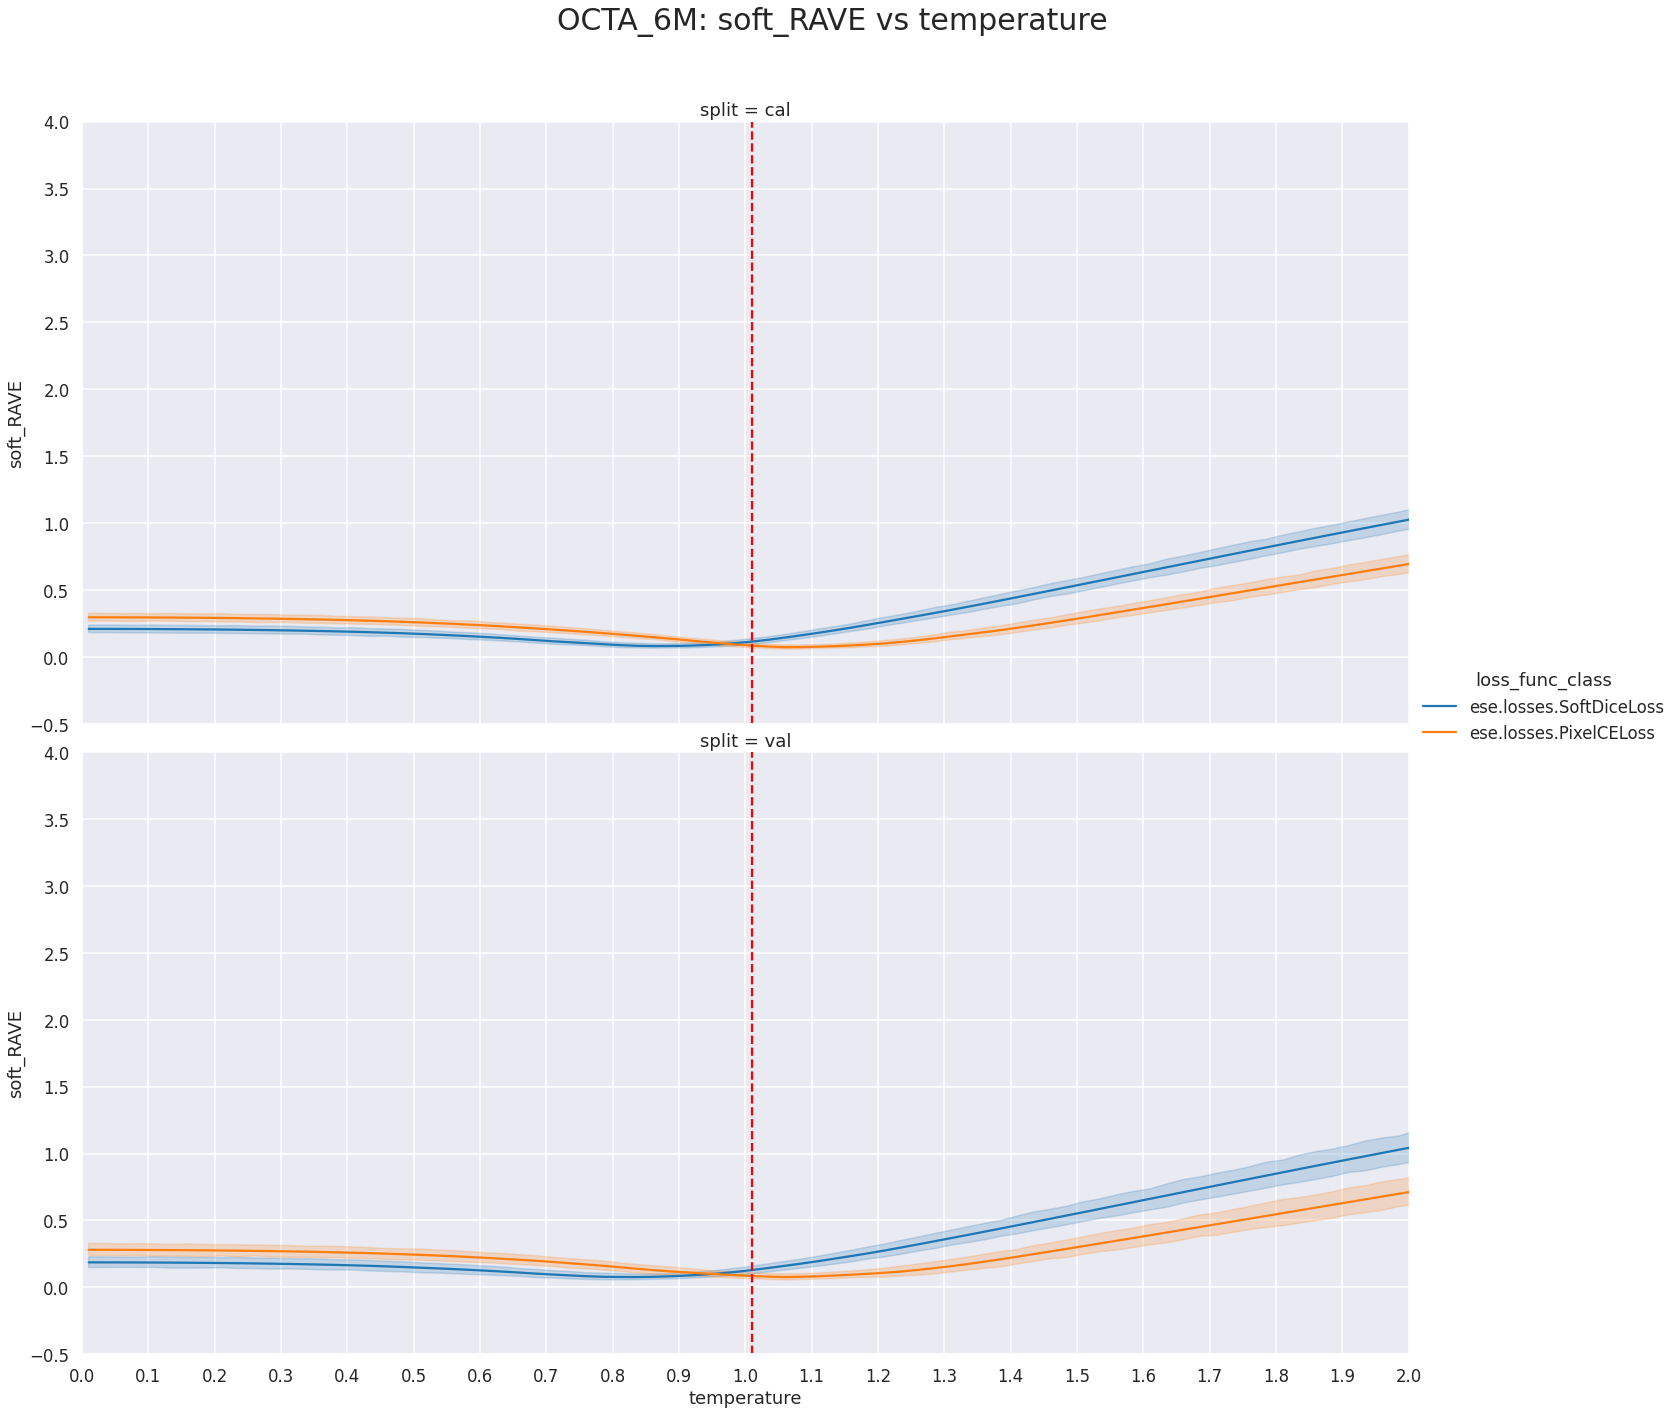

In [10]:
plt.figure(figsize=(30, 20))
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='loss_func_class',
    row='split',
    kind='line',
    height=10,
    aspect=aspect,
    legend=(x_key == 'temperature')
)
# If the x_key is temperature, place a dashed red vertical line at 1.01
if x_key == 'temperature':
    for ax in g.axes.flat:
        ax.axvline(x=1.01, color='r', linestyle='--')
else:
    for ax in g.axes.flat:
        ax.axvline(x=0.5, color='r', linestyle='--')

g.set(xticks=xtick_range, xlim=x_lims, ylim=y_lims)
# Make a global title using suptitle with some spacing
plt.suptitle(f'{exp_df["dataset"].unique()[0]}: {y_key} vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)

In [11]:
get_global_optimal_parameter(
    exp_df, 
    sweep_key=x_key, 
    y_key=y_key,
    group_keys=['split', 'loss_func_class']
).sort_values(y_key)

,split,loss_func_class,temperature,soft_RAVE
0,cal,ese.losses.PixelCELoss,1.060,0.072734
2,val,ese.losses.PixelCELoss,1.060,0.077352
3,val,ese.losses.SoftDiceLoss,0.835,0.077431
1,cal,ese.losses.SoftDiceLoss,0.860,0.081276


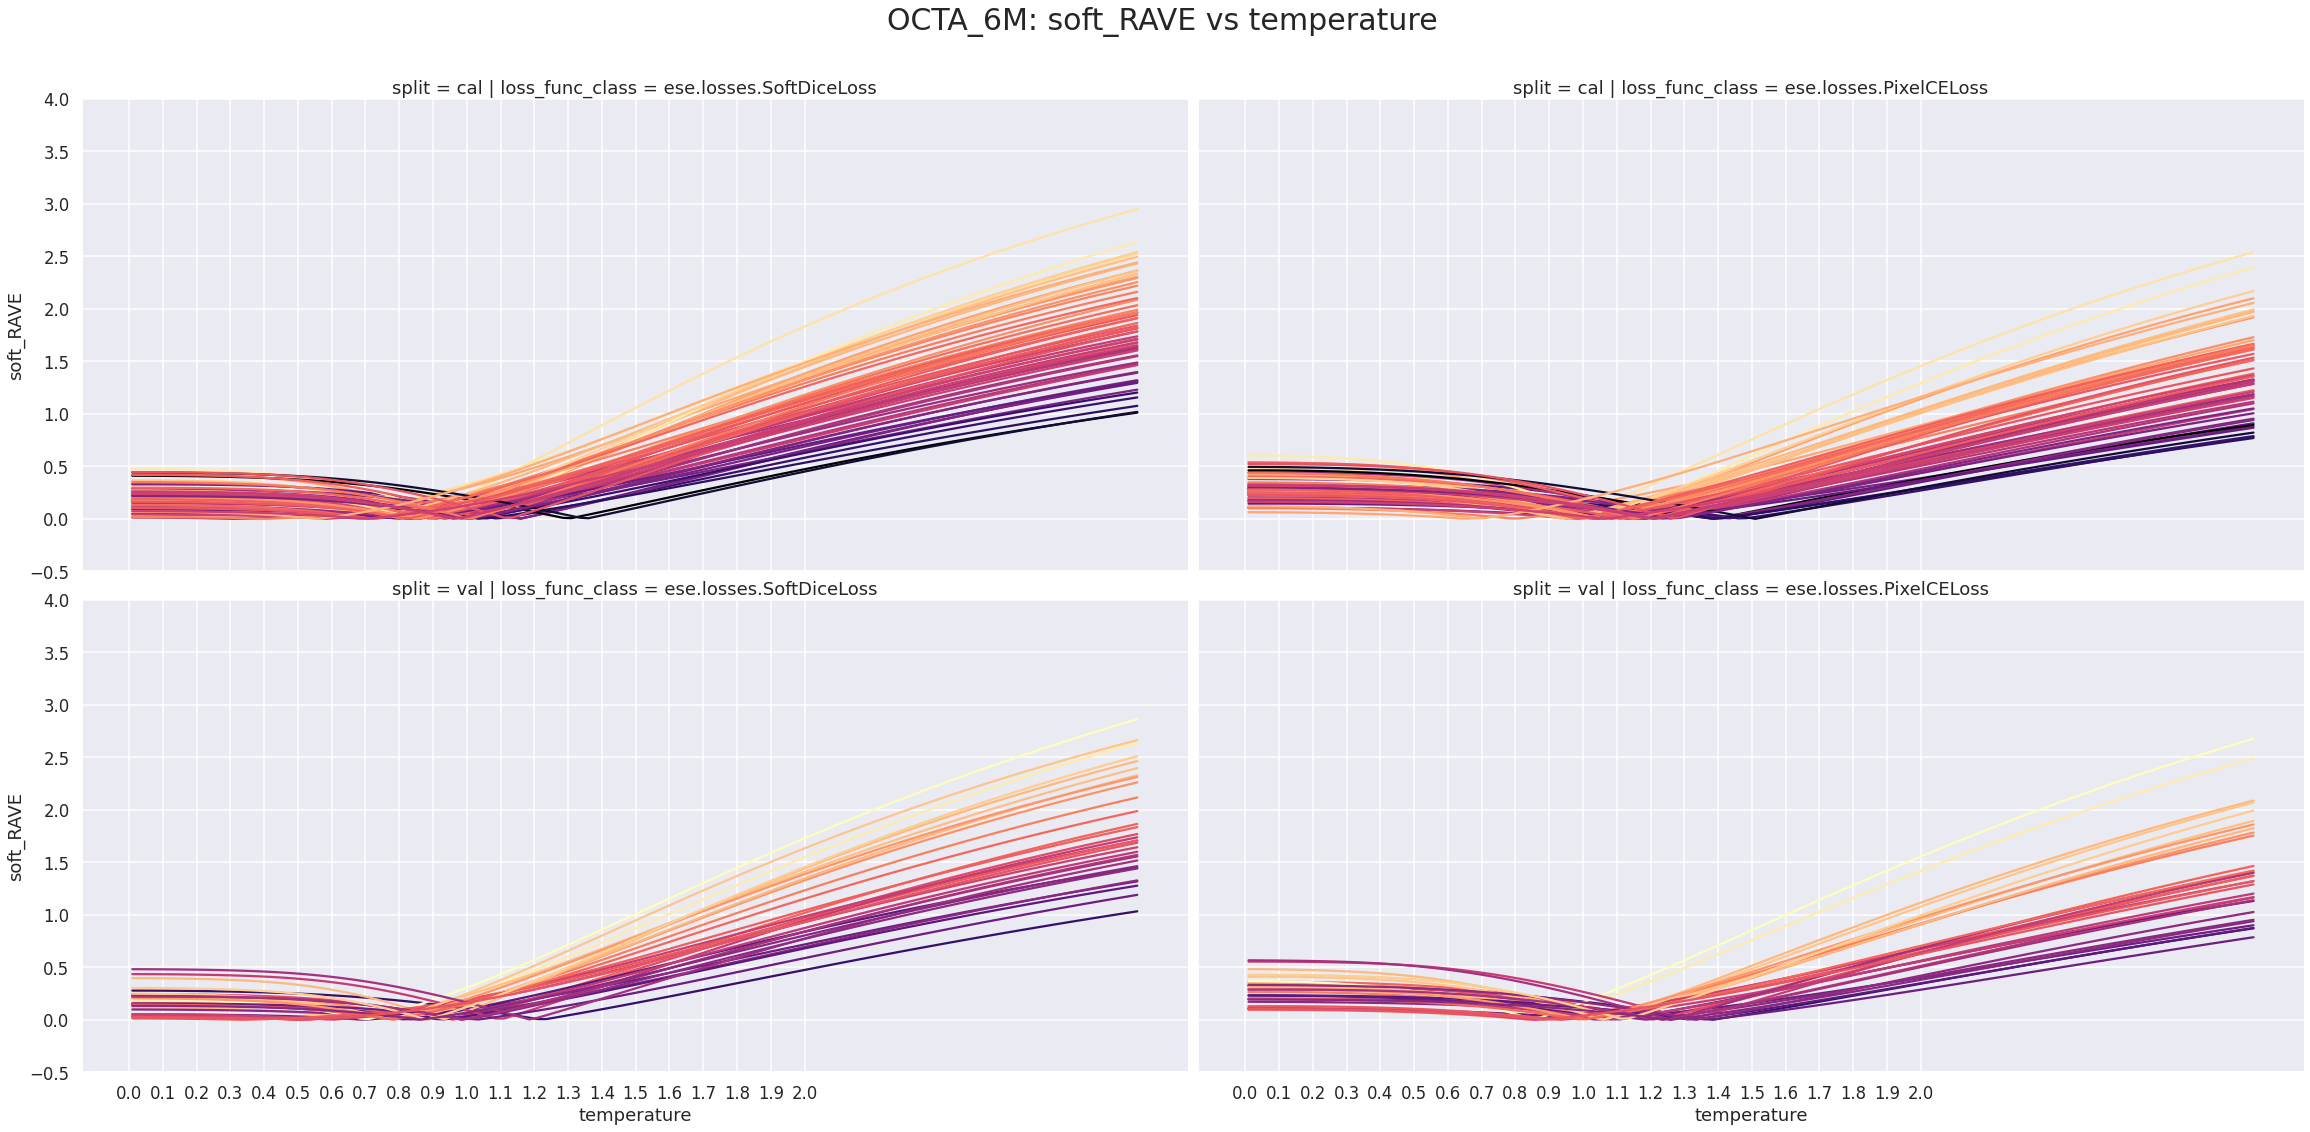

In [12]:
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='data_id',
    col='loss_func_class',
    row='split',
    # col='split',
    kind='line',
    height=8,
    aspect=aspect,
    legend=False,
    palette=get_prop_color_palette(
                exp_df, 
                hue_key='data_id', 
                magnitude_key='gt_volume',
                cmap=cmap
            )
)

g.set(xticks=xtick_range, ylim=y_lims)
# Make a global title using suptitle with some spacing
plt.suptitle(f'{exp_df["dataset"].unique()[0]}: {y_key} vs {x_key}', fontsize=30)
# Add spacing between the title and the plot
plt.subplots_adjust(top=0.9)

In [ ]:
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=exp_df,
    x=x_key,
    y=y_key,
    hue='data_id',
    col='loss_func_class',
    row='split',
    # col='split',
    kind='line',
    height=8,
    aspect=aspect,
    legend=False,
    palette=get_prop_color_palette(
                exp_df, 
                hue_key='data_id', 
                magnitude_key=('soft_volume' if x_key == 'threshold' else 'hard_volume'),
                cmap=cmap
            )
)

g.set(xticks=xtick_range, ylim=y_lims)

In [14]:
opt_perf_df, opt_temps_per_subj = get_per_subject_optimal_values(
    exp_df, 
    sweep_key=x_key, 
    y_key=y_key,
    group_keys=['split', 'loss_func_class'],
    keep_keys=['hard_volume', 'base_soft_volume', 'gt_volume'],
    return_optimal_values=True
)

In [ ]:
opt_temps_per_subj

In [16]:
def log_hard_volume(hard_volume):
    return np.log(hard_volume + 1)

def log_base_soft_volume(base_soft_volume):
    return np.log(base_soft_volume + 1)

def log_gt_volume(gt_volume):
    return np.log(gt_volume + 1)

opt_temps_per_subj.augment(log_hard_volume)
opt_temps_per_subj.augment(log_base_soft_volume)
opt_temps_per_subj.augment(log_gt_volume)

In [17]:
# Define a function to compute and annotate the correlation coefficient
def annotate_corr(data, **kws):
    x = data[kws['x_var']]
    y = data['temperature']
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(0.05, 0.95), xycoords=ax.transAxes,
                fontsize=25, verticalalignment='top', color='red')

def plot_feature_vs_temperature(x_feat):
    # Create the plot using sns.lmplot
    g = sns.lmplot(
        data=opt_temps_per_subj,
        x=x_feat,
        y='temperature',
        col='loss_func_class',
        row='split',
        height=8,
        aspect=aspect,
        scatter_kws={'s': 150},
        line_kws={'color': 'red'}
    )

    # Apply the annotation function to each subplot
    g.map_dataframe(annotate_corr, x_var=x_feat)

    # Adjust titles and layout
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f'{exp_df["dataset"].unique()[0]}: {x_feat} vs {x_key}', fontsize=30)
    plt.show()